# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland']

%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_rt(result, ax, country_name, scatter_alpha=1.0):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               alpha=scatter_alpha,
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [3]:
final_results = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [4]:
# TODO: fix column names in the MCMC notebook
final_results.columns = ['mean', 'ML', 'Low_90', 'High_90', 'Low_50', 'High_50']
final_results.index.names = ['country', 'date']

In [5]:
final_results

mean        ML    Low_90   High_90    Low_50   High_50
country date                                                                  
Poland  2020-02-16  1.477794  1.421487  1.059462  1.962684  1.194910  1.509106
        2020-02-17  1.482241  1.413967  1.063744  1.957752  1.152934  1.468134
        2020-02-18  1.485502  1.415224  1.082494  1.988320  1.141751  1.465709
        2020-02-19  1.489290  1.424345  1.067838  1.947710  1.179900  1.505897
        2020-02-20  1.491454  1.429107  1.067128  1.925114  1.145225  1.470856
...                      ...       ...       ...       ...       ...       ...
        2020-05-03  1.016958  1.012129  0.799878  1.196730  0.961273  1.090786
        2020-05-04  1.017664  1.016430  0.834951  1.236858  0.947646  1.085608
        2020-05-05  1.014594  1.013144  0.807346  1.228657  0.926756  1.072894
        2020-05-06  1.017428  1.014104  0.773443  1.251402  0.942263  1.101497
        2020-05-07  1.019924  1.017059  0.754076  1.257585  0.934336  1.095630

[82 rows x 6 columns]

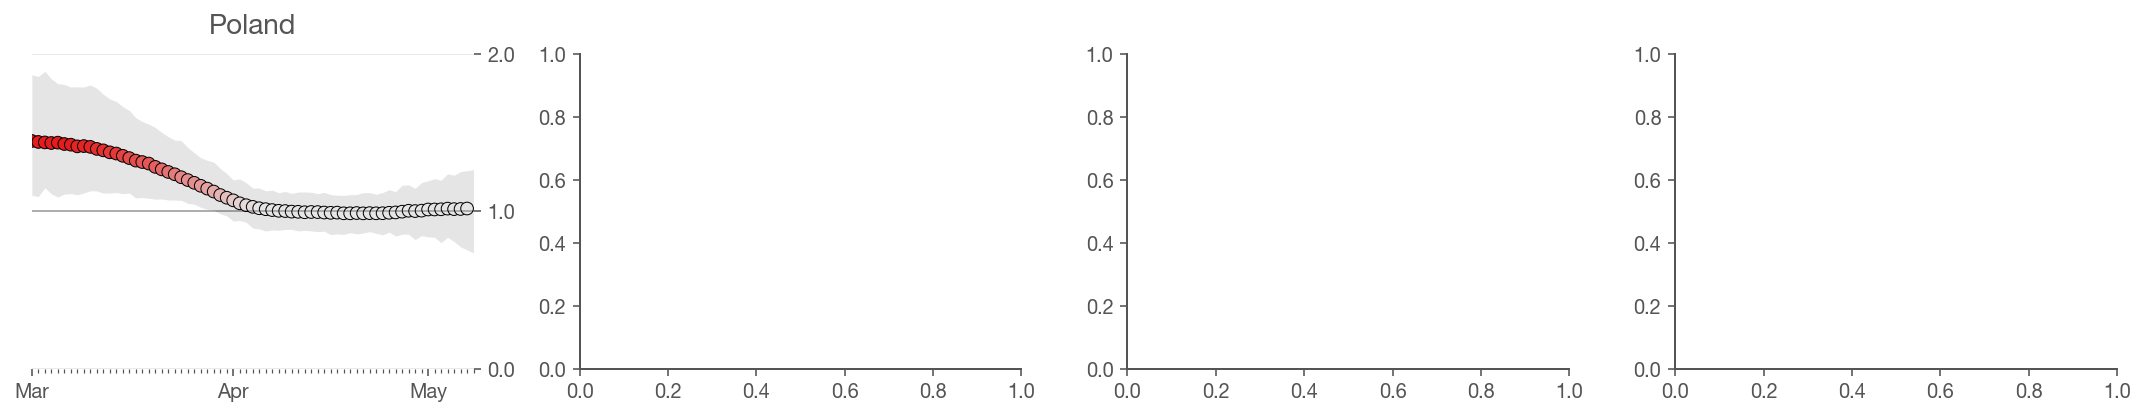

In [6]:
ncountries = len(final_results.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [7]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [8]:
no_lockdown = []
partial_lockdown = []

In [9]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    too_uncertain = mr.index[(mr['High_90'] - mr['Low_90']) > 1.2]

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)
        if country_name in too_uncertain:
            bar.set_alpha(0.3)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if not too_uncertain.empty:
        leg = ax.legend(handles=[
                    Patch(label='Insufficient data or an end of epidemy', color=FULL_COLOR, alpha=0.3),
                ],
#                 title='Lockdown',
#                 ncol=3,
                loc='upper left',
                columnspacing=.75,
                handletextpad=.5,
                handlelength=1)
        leg._legend_box.align = "left"

        
    fig.set_facecolor('w')
    return fig, ax

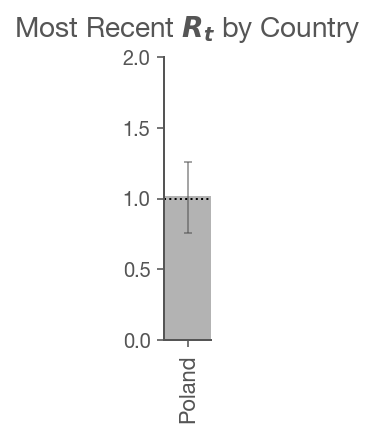

In [10]:
targets = final_results.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr = final_results.loc[targets].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()


mr.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr)

# Rainier

In [11]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [12]:
final_results_rainier

ML    Low_90   High_90
country        date                                    
Austria        2020-02-15  1.551122  1.106754  2.027601
               2020-02-16  1.555264  1.110010  2.004278
               2020-02-17  1.571706  1.127194  2.039733
               2020-02-18  1.575940  1.152555  2.057801
               2020-02-19  1.587142  1.135893  2.038621
...                             ...       ...       ...
United_Kingdom 2020-05-03  1.095251  1.000735  1.197777
               2020-05-04  1.109144  1.000351  1.217108
               2020-05-05  1.113887  0.987155  1.224687
               2020-05-06  1.110154  0.971704  1.233450
               2020-05-07  1.122770  0.967496  1.267802

[2656 rows x 3 columns]

In [13]:
final_results_rainier.columns = ['ML', 'Low_90', 'High_90']

In [14]:
final_results_rainier

ML    Low_90   High_90
country        date                                    
Austria        2020-02-15  1.551122  1.106754  2.027601
               2020-02-16  1.555264  1.110010  2.004278
               2020-02-17  1.571706  1.127194  2.039733
               2020-02-18  1.575940  1.152555  2.057801
               2020-02-19  1.587142  1.135893  2.038621
...                             ...       ...       ...
United_Kingdom 2020-05-03  1.095251  1.000735  1.197777
               2020-05-04  1.109144  1.000351  1.217108
               2020-05-05  1.113887  0.987155  1.224687
               2020-05-06  1.110154  0.971704  1.233450
               2020-05-07  1.122770  0.967496  1.267802

[2656 rows x 3 columns]

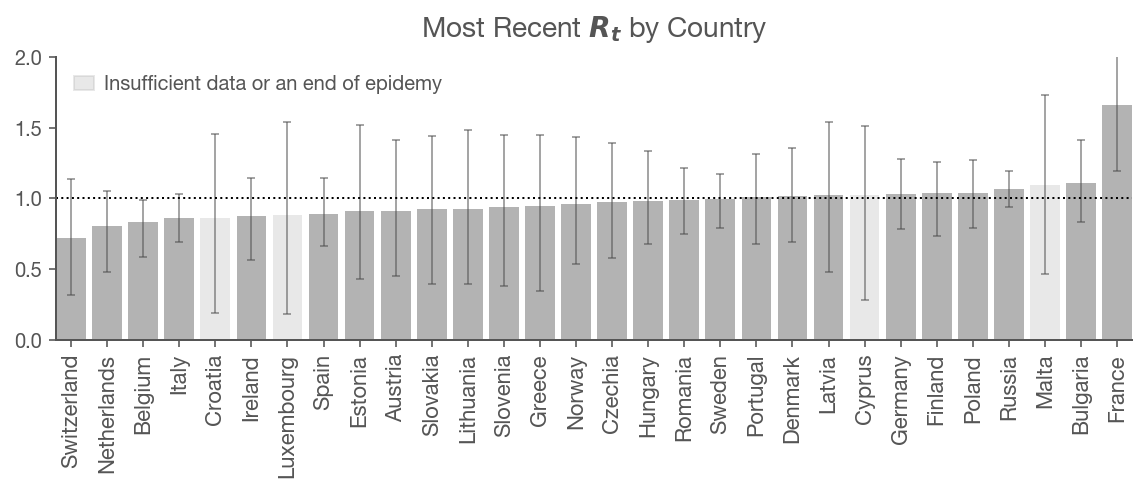

In [15]:
targets_rainier = final_results_rainier.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_rainier.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_rainier)

## Compare PYMC3's and Rainier's estimates for European countries

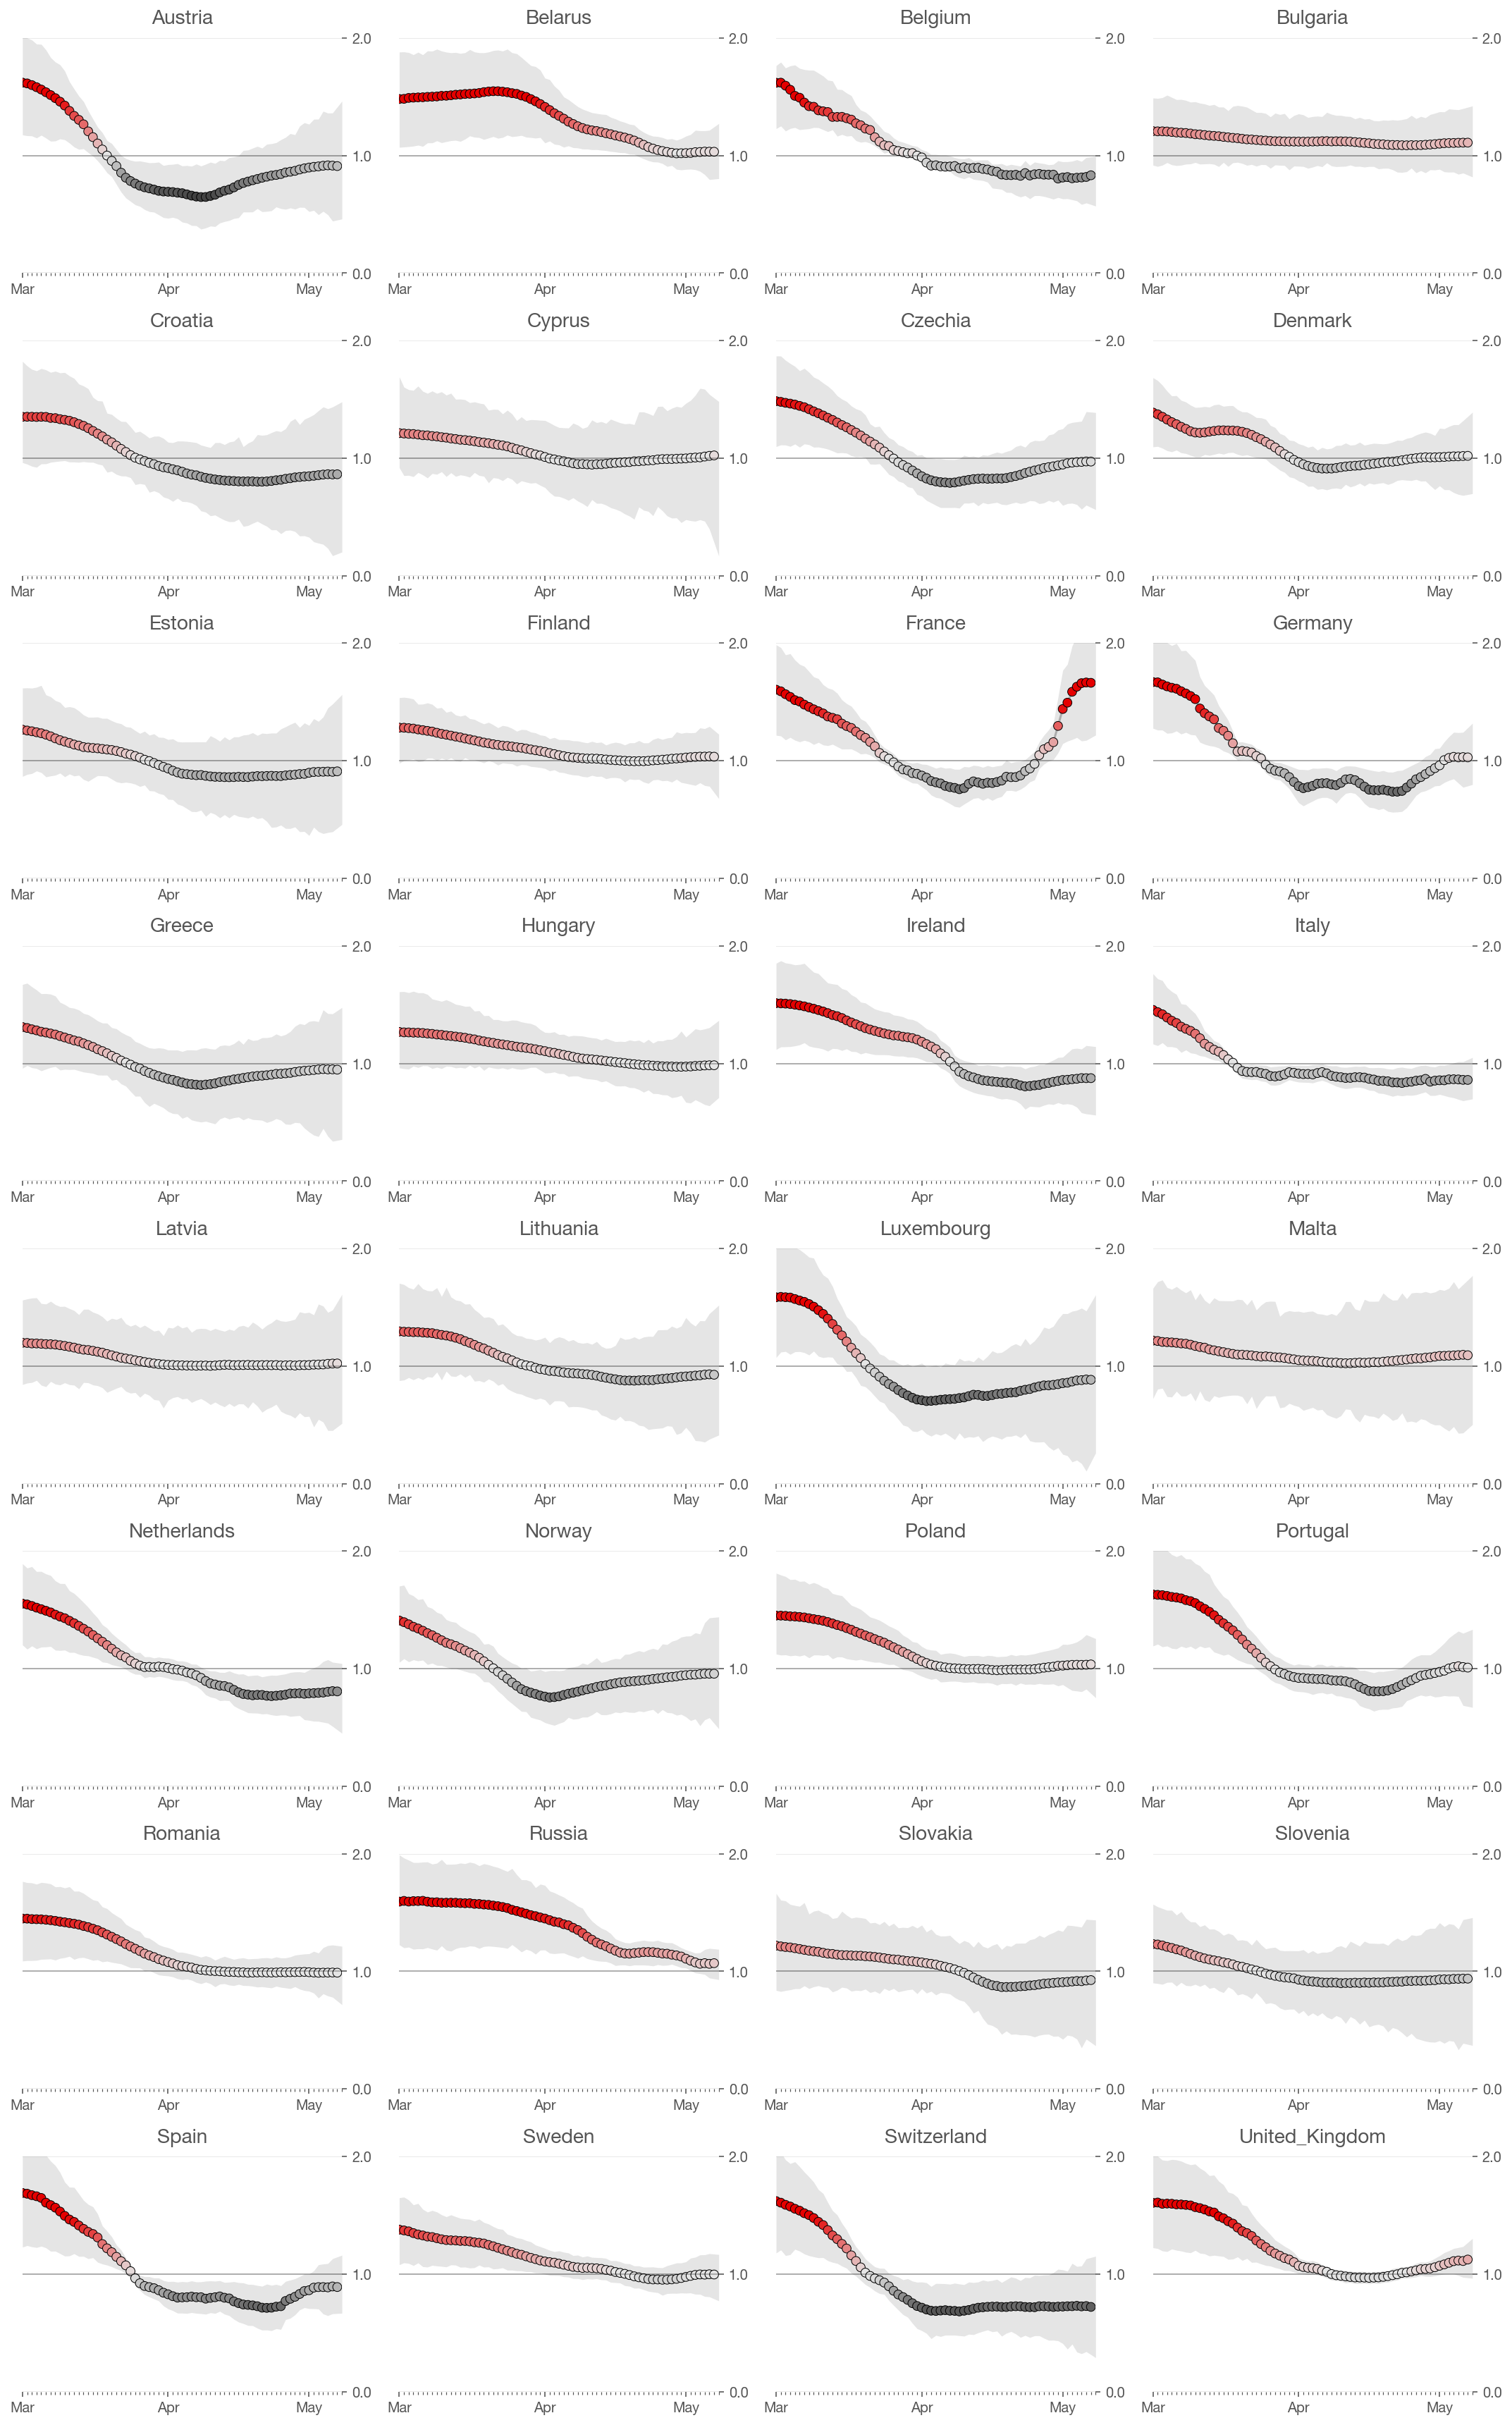

In [16]:
ncountries = len(final_results_rainier.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_rainier.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)
    
# for i, (country_name, result) in enumerate(final_results.groupby('country')):
#     plot_rt(result.iloc[1:], axes.flat[i], country_name, scatter_alpha=0.25)

fig.tight_layout()
fig.set_facecolor('w')